# How do socioeconomic factors affect crime rates in Seattle?
## Chantria Im, Ellie Velez, and Nawaf Osman

In [1]:
%%capture
%%script echo skipping # Skip this code cell

# Install packages
import sys
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install requests
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install matplotlib

In [2]:
# Import libraries
import pandas as pd
import requests
import re
import time
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Load datasets
crime_df = pd.read_csv('./data/SPD_Crime_Data__2008-Present_20240226.csv')
poverty_df = pd.read_csv('./data/Poverty_and_Near_Poverty_Map_Full_Data_data.csv', 
                         converters={'Census Tract': str.strip})
income_df = pd.read_csv('./data/ACSST5Y2018.S1903-Data.csv')

In [4]:
# Remove rows with missing Longitude and Latitude values
crime_df = crime_df[(crime_df['Longitude'] != 0) & (crime_df['Latitude'] != 0)]

# Filter for only 2018 entries
crime_df['Report DateTime'] = pd.to_datetime(crime_df['Report DateTime'], format='%m/%d/%Y %I:%M:%S %p')
crime_df = crime_df[crime_df['Report DateTime'].dt.year == 2018]

# Add Census Tract column
crime_df['Census Tract'] = pd.Series(dtype='string')

In [5]:
%%capture
%%script echo skipping # Skip this code cell

# Fill Census Tract column with corresponding census tract numbers
i = 0
while i < len(crime_df):
    # Make request to Census Geocoder API to get row's census tract data based on row's longtitude and latitude values
    payload = {'benchmark': 'Public_AR_Current', 'vintage': 'ACS2018_Current', 'x': crime_df['Longitude'].iloc[i], 
               'y': crime_df['Latitude'].iloc[i], 'format': 'json', 'layers': 'Census Tracts'}
    try:
        r = requests.get(f'https://geocoding.geo.census.gov/geocoder/geographies/coordinates', params=payload)
    except requests.Timeout:
        time.sleep(300)
        continue
    # Extract the census tract number from the response and store it in the Census Tract column
    crime_df['Census Tract'].iloc[i] = re.findall('\d+\.\d+|\d+', 
                                                  r.json()['result']['geographies']['Census Tracts'][0]['NAME'])[0]
    i += 1

# Backup dataframe to disk 
crime_df.to_csv('./data/crime.csv')

In [6]:
pd.set_option('display.max_colwidth', None)

# Cache the dataframe
# %store crime_df
# Reload the dataframe from cache rather than recomputing (5+ hours)
%store -r crime_df

In [7]:
# Drop empty columns
poverty_df = poverty_df.drop(['% of Population Under 100% Poverty Line', '% of Population Under 200% Poverty Line', 
                              'Share Below Selected % of Poverty Level'], axis=1)

# Group data by census tract and calculate total poverty population for levels
poverty_by_tract = poverty_df[poverty_df['Name'] != 'Total'].groupby('Census Tract').agg(
    {'Population Under 100% Poverty Level': 'sum', 'Population Under 200% Poverty Level': 'sum'})

# For each census tract fill designated 'Total' row with total poverty populations for levels
poverty_df.loc[
    poverty_df['Name'] == 'Total', 
    'Population Under 100% Poverty Level'] = poverty_df.loc[
    poverty_df['Name'] == 'Total', 'Census Tract'].map(poverty_by_tract['Population Under 100% Poverty Level']).values
poverty_df.loc[
    poverty_df['Name'] == 'Total', 
    'Population Under 200% Poverty Level'] = poverty_df.loc[
    poverty_df['Name'] == 'Total', 'Census Tract'].map(poverty_by_tract['Population Under 200% Poverty Level']).values

# Filter for only designated 'Total' rows
poverty_df = poverty_df[poverty_df['Name'] == 'Total']

In [8]:
# Remove rows with missing median income values
income_df = income_df[pd.to_numeric(income_df['S1903_C03_001E'], errors='coerce').notna()] # 53.02 UDistrict Missing

# Extract and set census tract numbers
for i in range(len(income_df)):
    income_df.iat[i, income_df.columns.get_loc('NAME')] = re.findall('\d+\.\d+|\d+', income_df['NAME'].iloc[i])[0]
    
# Edit column names
income_df = income_df.rename(columns={'NAME': 'Census Tract', 'S1903_C03_001E': 'Median Income'})

# Set median income column to numeric type
income_df['Median Income'] = pd.to_numeric(income_df['Median Income'])

In [9]:
# Drop un-needed columns
crime_df = crime_df.filter(['Census Tract', 'Offense Start DateTime', 'Offense End DateTime', 'Report DateTime', 
                            'Offense Parent Group'])
poverty_df = poverty_df.filter(['Census Tract', 'Population Under 100% Poverty Level', 
                                'Population Under 200% Poverty Level', 'Total Population'])
income_df = income_df.filter(['Census Tract', 'Median Income'])

In [10]:
# Merge datasets
merged_df = crime_df.merge(poverty_df, on='Census Tract')
merged_df = merged_df.merge(income_df, on='Census Tract')

# Augment poverty columns to percentage
merged_df['Population Under 100% Poverty Level'] /= merged_df['Total Population']
merged_df['Population Under 200% Poverty Level'] /= merged_df['Total Population']

In [11]:
# Calculate total crime offenses by census tract
grouped_df = merged_df.groupby('Census Tract').agg({
    'Population Under 100% Poverty Level': 'first',
    'Population Under 200% Poverty Level': 'first',
    'Total Population': 'first',
    'Median Income': 'first',
    'Offense Parent Group': 'count'
})
grouped_df = grouped_df.rename(columns={'Offense Parent Group': 'Total Offenses'})

# Calculate crime rate per census tract
# Crime rate is calculated by: total crime offenses / total population * 100,000
grouped_df['Crime Rate per 100,000'] = (grouped_df['Total Offenses'] / grouped_df['Total Population']) * 100000
grouped_df['Crime Rate per 100,000'] = grouped_df['Crime Rate per 100,000'].round()

In [12]:
# Calculate crime rate per census tract by offense type
offenses_df = merged_df.groupby(['Census Tract', 'Population Under 100% Poverty Level', 
                                 'Population Under 200% Poverty Level', 'Total Population', 
                                 'Median Income', 'Offense Parent Group']).size().reset_index(name='Offense Count')
offenses_df['Crime Rate per 100,000'] = (offenses_df['Offense Count'] / offenses_df['Total Population']) * 100000
offenses_df['Crime Rate per 100,000'] = offenses_df['Crime Rate per 100,000'].round()

In [13]:
# Remove rows with missing Offense Start and End DateTime values
policing_df = merged_df[merged_df['Offense Start DateTime'].notna() & 
                        merged_df['Offense End DateTime'].notna()].copy() # Missing 204.02, 260.02, 264

# Change column types to DateTime
policing_df['Offense Start DateTime'] = pd.to_datetime(policing_df['Offense Start DateTime'], 
                                                       format='%m/%d/%Y %I:%M:%S %p')
policing_df['Offense End DateTime'] = pd.to_datetime(policing_df['Offense End DateTime'], 
                                                     format='%m/%d/%Y %I:%M:%S %p')

# Calculate time between offense start time, offense end time, and report time for each offense
policing_df['Start-Report Time Diff'] = (policing_df['Report DateTime'] - 
                                         policing_df['Offense Start DateTime']).dt.total_seconds() / 60
policing_df['End-Report Time Diff'] = (policing_df['Report DateTime'] - 
                                       policing_df['Offense End DateTime']).dt.total_seconds() / 60

# Calculate average policing times for each census tract
policing_df = policing_df.groupby('Census Tract').agg({
    'Start-Report Time Diff': 'mean',
    'End-Report Time Diff': 'mean',
    'Population Under 100% Poverty Level': 'first',
    'Population Under 200% Poverty Level': 'first',
    'Median Income': 'first'
}).reset_index()

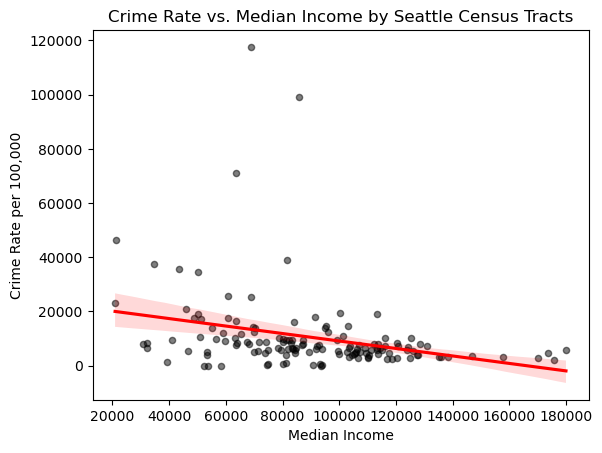

In [15]:
# Crime rate vs median income scatter plot
sns.regplot(x=grouped_df['Median Income'], y=grouped_df['Crime Rate per 100,000'], color='red', 
            scatter_kws={'s': 20, 'color': 'black', 'alpha': 0.5})
plt.title('Crime Rate vs. Median Income by Seattle Census Tracts')
plt.xlabel('Median Income')
plt.ylabel('Crime Rate per 100,000')
plt.show()

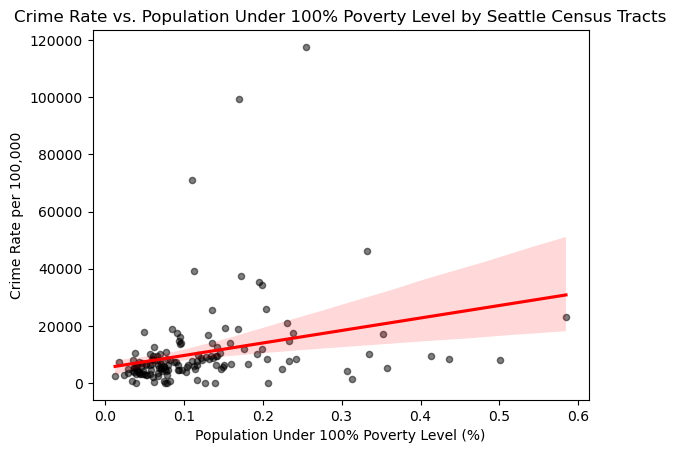

In [16]:
# Crime rate vs under 100% poverty level scatter plot
sns.regplot(x=grouped_df['Population Under 100% Poverty Level'], y=grouped_df['Crime Rate per 100,000'], color='red', 
           scatter_kws={'s': 20, 'color': 'black', 'alpha': 0.5})
plt.title('Crime Rate vs. Population Under 100% Poverty Level by Seattle Census Tracts')
plt.xlabel('Population Under 100% Poverty Level (%)')
plt.ylabel('Crime Rate per 100,000')
plt.show()

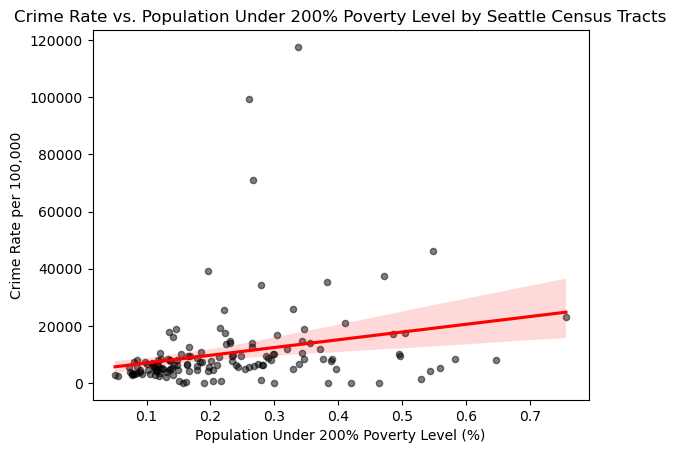

In [17]:
# Crime rate vs under 200% poverty level scatter plot
sns.regplot(x=grouped_df['Population Under 200% Poverty Level'], y=grouped_df['Crime Rate per 100,000'], color='red', 
           scatter_kws={'s': 20, 'color': 'black', 'alpha': 0.5})
plt.title('Crime Rate vs. Population Under 200% Poverty Level by Seattle Census Tracts')
plt.xlabel('Population Under 200% Poverty Level (%)')
plt.ylabel('Crime Rate per 100,000')
plt.show()

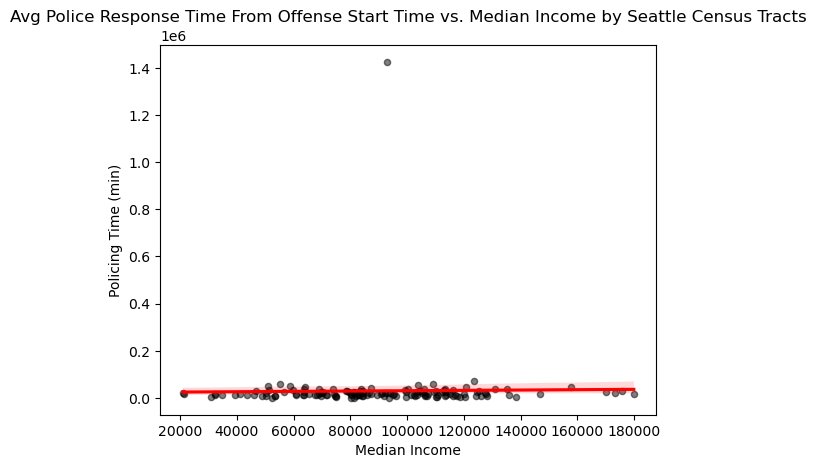

In [21]:
# Policing time from offense start time vs median income scatter plot
sns.regplot(x=policing_df['Median Income'], y=policing_df['Start-Report Time Diff'], color='red', 
            scatter_kws={'s': 20, 'color': 'black', 'alpha': 0.5})
plt.title('Avg Police Response Time From Offense Start Time vs. Median Income by Seattle Census Tracts')
plt.xlabel('Median Income')
plt.ylabel('Policing Time (min)')
plt.show()

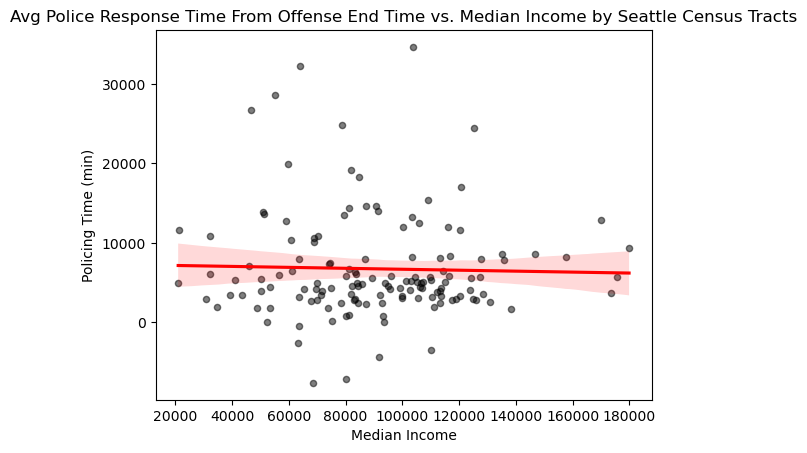

In [22]:
# Policing time from offense end time vs median income scatter plot
sns.regplot(x=policing_df['Median Income'], y=policing_df['End-Report Time Diff'], color='red', 
            scatter_kws={'s': 20, 'color': 'black', 'alpha': 0.5})
plt.title('Avg Police Response Time From Offense End Time vs. Median Income by Seattle Census Tracts')
plt.xlabel('Median Income')
plt.ylabel('Policing Time (min)')
plt.show()

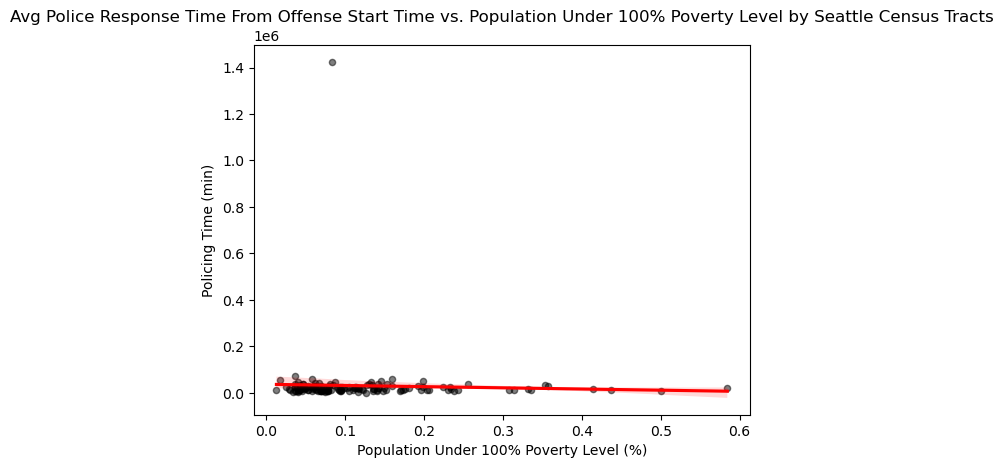

In [24]:
# Policing time from offense start time vs under 100% poverty level scatter plot
sns.regplot(x=policing_df['Population Under 100% Poverty Level'], y=policing_df['Start-Report Time Diff'], color='red', 
           scatter_kws={'s': 20, 'color': 'black', 'alpha': 0.5})
plt.title('Avg Police Response Time From Offense Start Time vs. Population Under 100% Poverty Level by Seattle Census Tracts')
plt.xlabel('Population Under 100% Poverty Level (%)')
plt.ylabel('Policing Time (min)')
plt.show()

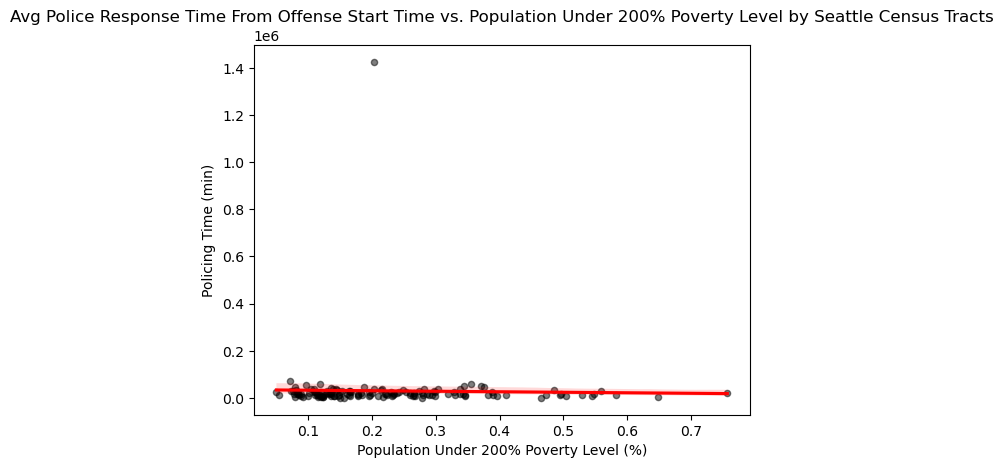

In [25]:
# Policing time from offense start time vs under 200% poverty level scatter plot
sns.regplot(x=policing_df['Population Under 200% Poverty Level'], y=policing_df['Start-Report Time Diff'], color='red', 
           scatter_kws={'s': 20, 'color': 'black', 'alpha': 0.5})
plt.title('Avg Police Response Time From Offense Start Time vs. Population Under 200% Poverty Level by Seattle Census Tracts')
plt.xlabel('Population Under 200% Poverty Level (%)')
plt.ylabel('Policing Time (min)')
plt.show()

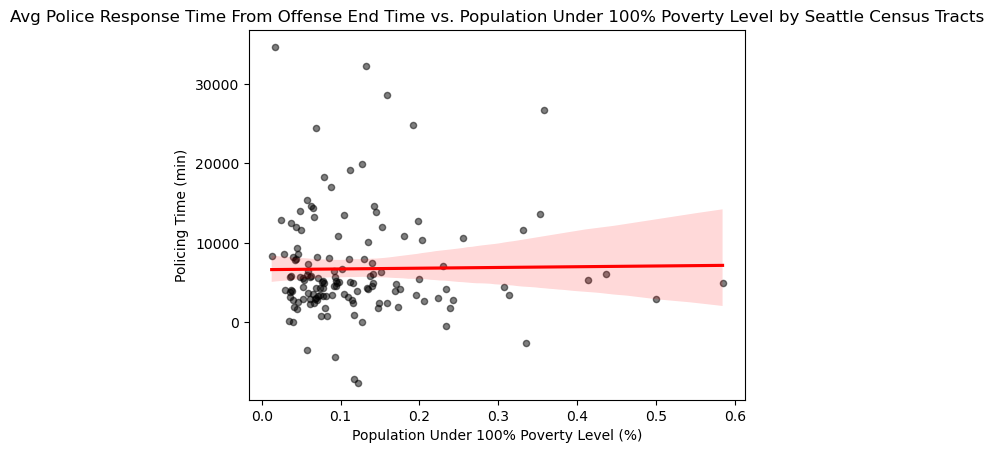

In [26]:
# Policing time from offense end time vs under 100% poverty level scatter plot
sns.regplot(x=policing_df['Population Under 100% Poverty Level'], y=policing_df['End-Report Time Diff'], color='red', 
           scatter_kws={'s': 20, 'color': 'black', 'alpha': 0.5})
plt.title('Avg Police Response Time From Offense End Time vs. Population Under 100% Poverty Level by Seattle Census Tracts')
plt.xlabel('Population Under 100% Poverty Level (%)')
plt.ylabel('Policing Time (min)')
plt.show()

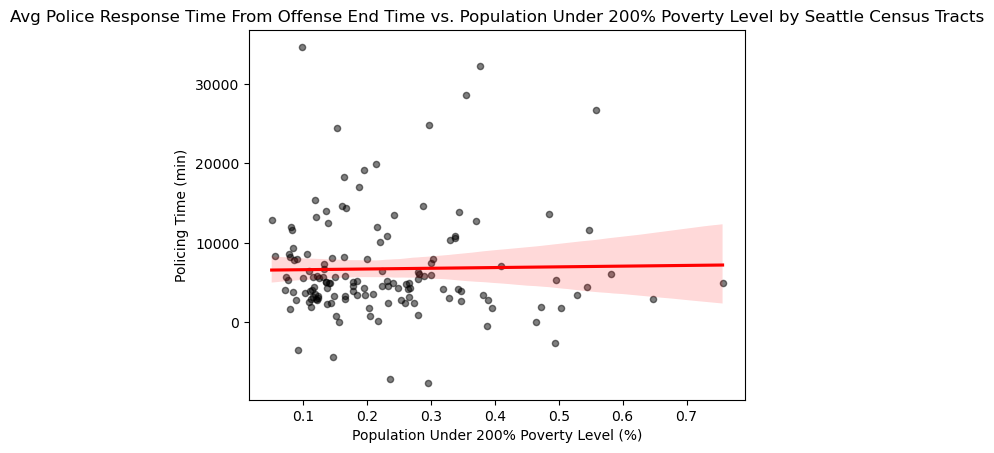

In [27]:
# Policing time from offense end time vs under 200% poverty level scatter plot
sns.regplot(x=policing_df['Population Under 200% Poverty Level'], y=policing_df['End-Report Time Diff'], color='red', 
           scatter_kws={'s': 20, 'color': 'black', 'alpha': 0.5})
plt.title('Avg Police Response Time From Offense End Time vs. Population Under 200% Poverty Level by Seattle Census Tracts')
plt.xlabel('Population Under 200% Poverty Level (%)')
plt.ylabel('Policing Time (min)')
plt.show()